In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import tushare as ts
pro = ts.pro_api('2f8168a08ce71c9655c5b633b3dc17088bfc6f5a07e629f38f1c3d1f')

In [2]:
tscode='600552.SH'

In [7]:
df=pd.read_feather('D:/OneDrive - 厦门深数信息科技有限公司/deepdata_share/projects/quant_trade/backtrader/df.feather')
df=df.loc[df['ts_code']==tscode[:-3]]

In [10]:
df

,ts_code,trade_date,close_qfq,open_qfq,high_qfq,low_qfq,vol,pre,std,pro,1d,var,fE,fstr,Bpro
0,600552,2003-04-10,1.47240,1.43299,1.47479,1.41866,11011.49,-0.039291,0.093913,33.783832,0.000000,0.000000,0.000000,0.000000,NaN
1,600552,2003-04-11,1.47240,1.46881,1.47837,1.45210,6852.77,-0.002148,0.093913,49.087475,0.025951,0.018350,0.022048,0.017956,NaN
2,600552,2003-04-15,1.51061,1.50464,1.52852,1.49270,17638.17,-0.014062,0.093913,44.048646,-0.027671,0.021902,-0.023269,0.021411,10.974171
3,600552,2003-04-16,1.46881,1.51658,1.52016,1.46643,13281.41,-0.013469,0.093913,44.297935,0.016265,0.020638,0.013789,0.020190,86.142800
4,600552,2003-04-17,1.49270,1.46881,1.51539,1.46404,10969.39,0.005879,0.093913,52.495937,-0.028003,0.022306,-0.023545,0.021806,24.731295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,600552,2023-07-24,11.81000,11.84000,11.97000,11.80000,77588.00,0.002312,0.093913,50.981823,0.014395,0.033811,0.012256,0.033072,62.418133
4602,600552,2023-07-25,11.98000,11.88000,12.08000,11.85000,120336.27,-0.001580,0.093913,49.328963,-0.004174,0.033807,-0.003406,0.033062,35.547654
4603,600552,2023-07-26,11.93000,11.95000,12.09000,11.86000,95300.94,0.008924,0.093913,53.785069,-0.008382,0.033804,-0.006956,0.033058,54.102896
4604,600552,2023-07-27,11.83000,11.88000,12.00000,11.83000,74152.60,0.002624,0.093913,51.114469,0.011834,0.033800,0.010096,0.033061,58.333308


In [9]:
df['Bpro']=df['Bpro'].shift(1)

In [11]:
df.columns

Index(['ts_code', 'trade_date', 'close_qfq', 'open_qfq', 'high_qfq', 'low_qfq',
       'vol', 'pre', 'std', 'pro', '1d', 'var', 'fE', 'fstr', 'Bpro'],
      dtype='object')

In [13]:
df['trade_date']=df['trade_date'].astype(str)
df['Datetime']=pd.to_datetime(df['trade_date'])
df['volume']=df['vol']
df['openinterest']=0
df.set_index('Datetime',inplace=True)
df.sort_index(inplace=True,ascending=True)
df=df[['open_qfq', 'high_qfq', 'low_qfq','close_qfq', 'volume', 'openinterest', 'pre','pro', '1d','Bpro']]

In [21]:
class CustomPandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'volume', 'openinterest', 'pre','pro','1d','Bpro')
    params = (('open',0), ('high', 1), ('low', 2), ('close', 3), ('volume', 4), ('openinterest', 5), ('pre', 6), ('pro', 7), ('1d', 8), ('Bpro', 9))
res = CustomPandasData(dataname=df,fromdate=dt.datetime(2023,1,1),todate=dt.datetime(2023,7,31),timeframe=bt.TimeFrame.Days)

买入：
分布大于70且没有触发止损信号：
若第一次买则买入
若要加仓 总收益率必须为正 且只能加仓二次
卖出：
达到目标收益止盈
持有60天内日收益率达不到年化要求
收益率到达止损空间
收益率分布小于40

In [63]:
class st5(bt.Strategy):#先买后卖
    def __init__(self):
        self.dataclose = self.data0.close
        self.distribution = self.data0.pro
        self.profit_target = 0.04  # 5%的收益目标
        self.stop_target = -0.05
        self.daily_return_threshold = 0.000386
        self.total_return = 0  # 总收益率
        self.buy_transaction =pd.DataFrame(columns=['成本','day']) # 买入交易记录
        self.buy_times=-1
        self.stop_mark=False
        self.stop_loss=0.01
        self.log=pd.DataFrame(columns=['日期','行为','价格','信号','价值','操作利润','平均收益','平均日收益','value变化'])
        self.sma5=bt.ind.SimpleMovingAverage(self.dataclose,period=5)
        self.order = None
        self.tvalue=100000
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                buy_transaction = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'成本': [order.executed.price], 'day': [1]})
                self.buy_transaction = pd.concat([self.buy_transaction, buy_transaction])
                self.buy_times+=1
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [order.executed.price],
                                    '信号':['买入成功'],'价值':[order.executed.value]})
                self.log = pd.concat([self.log, log])
            elif order.issell():
                self.buy_transaction =pd.DataFrame(columns=['成本','day'])
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [order.executed.price],
                                    '信号':['卖出成功'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                   '操作利润':[order.executed.pnl]})
                self.log = pd.concat([self.log, log])
                self.buy_times=-1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['取消'],'价格': [order.executed.price],
                                    '信号':['操作取消']})
                self.log = pd.concat([self.log, log])
        # Write down: no pending order
        self.order = None
    def next(self):
        buy_price = self.data0.close[0]  # 获取当前的买入价格
        if self.distribution[0] >70 and self.stop_mark==False:   
            if self.buy_times==-1:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
            elif self.buy_times!=-1 and self.total_return>0 and self.buy_times<3:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
        if self.position:
            current_value=self.broker.get_value()
            pnl=(current_value-self.tvalue)/self.tvalue
            self.total_return=(self.data.close[0]-self.buy_transaction['成本'])/self.buy_transaction['成本']
            self.total_return=self.total_return.mean()
            if not self.buy_transaction.empty and not self.buy_transaction['day'].isnull().all():
                self.average_return = self.total_return / int(self.buy_transaction['day'].mean())
            else:
                self.average_return = np.nan
            if pnl>self.profit_target:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [self.data.close[0]],
                                    '信号':['4%到手'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                   'value变化':[pnl]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif  self.average_return < self.daily_return_threshold and self.buy_transaction['day'].max()>=60:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],
                                    '信号':['日均较低'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                    'value变化':[pnl]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif pnl<=self.stop_target:
                self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],
                                    '信号':['止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                    'value变化':[pnl]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.distribution[0]<30:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],
                                    '信号':['卖出分布'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                    'value变化':[pnl]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            if not self.buy_transaction.empty:
                self.buy_transaction['day']+=1
    def stop(self):
        self.log.to_excel('log.xlsx',index=None)

In [227]:
class st7(bt.Strategy):#先买后卖
    def __init__(self):
        self.dataclose = self.data0.close
        self.distribution = self.data0.pro
        self.profit_target = 0.04  # 5%的收益目标
        self.stop_target = -0.1
        self.daily_return_threshold = 0.000386
        self.holding_days = 0  # 持仓天数
        self.total_return = 0  # 总收益率
        self.buy_transaction =pd.DataFrame(columns=['成本','day']) # 买入交易记录
        self.buy_times=-1
        self.stop_mark=False
        self.stop_loss=0.1
        self.log=pd.DataFrame(columns=['日期','行为','价格','信号','价值','操作利润','平均收益','平均日收益'])
        self.sma5=bt.ind.SimpleMovingAverage(self.dataclose,period=5)
        self.order = None
        self.pvalue=self.broker.get_value()
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                buy_price = self.data0.close[0]
                buy_transaction = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'成本': [order.executed.price], 'day': [1]})
                self.buy_transaction = pd.concat([self.buy_transaction, buy_transaction])
                self.buy_times+=1
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [order.executed.price],
                                   '信号':['买入成功'],'价值':[order.executed.value]})
                self.log = pd.concat([self.log, log])
            elif order.issell():
                self.buy_transaction =pd.DataFrame(columns=['成本','day'])
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [order.executed.price],
                                  '信号':['卖出成功'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                  '操作利润':[order.executed.pnl]})
                self.log = pd.concat([self.log, log])
                self.buy_times=-1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['取消'],'价格': [order.executed.price],
                                   '信号':['操作取消'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
        # Write down: no pending order
        self.order = None
    def next(self):
        buy_price = self.data0.close[0]  # 获取当前的买入价格
        if self.distribution[0] >60 and self.stop_mark==False:   
            if self.buy_times==-1:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
            elif self.buy_times!=-1 and self.total_return>0 and self.buy_times<3:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
        if self.position:
            current_value=self.broker.get_value()
            pnl=(current_value-self.pvalue)/self.pvalue
            self.total_return=(self.data.close[0]-self.buy_transaction['成本'])/self.buy_transaction['成本']
            self.total_return=self.total_return.mean()
            if not self.buy_transaction.empty and not self.buy_transaction['day'].isnull().all():
                self.average_return = self.total_return / int(self.buy_transaction['day'].mean())
            else:
                self.average_return = np.nan
            if self.total_return>self.profit_target:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [self.data.close[0]],'信号':['4%到手'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif  self.average_return < self.daily_return_threshold and self.buy_transaction['day'].max()>=60:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['日均较低'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.total_return <=self.stop_target:
                self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.distribution[0]<30:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['卖出分布'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif pnl<=-self.stop_loss:
                self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['本金止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            if not self.buy_transaction.empty:
                self.buy_transaction['day']+=1
    def stop(self):
        self.log.to_excel('log3.xlsx',index=None)

In [42]:
class st10(bt.Strategy):#只能卖后买
    def __init__(self):
        self.dataclose = self.data0.close
        self.distribution = self.data0.pro
        self.profit_target = 0.04  # 5%的收益目标
        self.stop_target = -0.1
        self.daily_return_threshold = 0.000386
        self.holding_days = 0  # 持仓天数
        self.total_return = 0  # 总收益率
        self.buy_transaction =pd.DataFrame(columns=['成本','day']) # 买入交易记录
        self.buy_times=-1
        self.stop_mark=False
        self.stop_loss=0.1
        self.log=pd.DataFrame(columns=['日期','行为','价格','信号','价值','操作利润','平均收益','平均日收益'])
        self.sma5=bt.ind.SimpleMovingAverage(self.dataclose,period=5)
        self.order = None
        self.pvalue=self.broker.get_value()
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                buy_price = self.data0.close[0]
                buy_transaction = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'成本': [order.executed.price], 'day': [1]})
                self.buy_transaction = pd.concat([self.buy_transaction, buy_transaction])
                self.buy_times+=1
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [order.executed.price],
                                   '信号':['买入成功'],'价值':[order.executed.value]})
                self.log = pd.concat([self.log, log])
            elif order.issell():
                self.buy_transaction =pd.DataFrame(columns=['成本','day'])
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [order.executed.price],
                                  '信号':['卖出成功'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                  '操作利润':[order.executed.pnl]})
                self.log = pd.concat([self.log, log])
                self.buy_times=-1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['取消'],'价格': [order.executed.price],
                                   '信号':['操作取消'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
        # Write down: no pending order
        self.order = None
    def next(self):
        buy_price = self.data0.close[0]  # 获取当前的买入价格
        if self.position:
            current_value=self.broker.get_value()
            pnl=(current_value-self.pvalue)/self.pvalue
            self.total_return=(self.data.close[0]-self.buy_transaction['成本'])/self.buy_transaction['成本']
            self.total_return=self.total_return.mean()
            if not self.buy_transaction.empty and not self.buy_transaction['day'].isnull().all():
                self.average_return = self.total_return / int(self.buy_transaction['day'].mean())
            else:
                self.average_return = np.nan
            if self.total_return>self.profit_target:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [self.data.close[0]],'信号':['4%到手'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif  self.average_return < self.daily_return_threshold and self.buy_transaction['day'].max()>=60:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['日均较低'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.total_return <=self.stop_target:
                self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.distribution[0]<30:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['卖出分布'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif pnl<=-self.stop_loss:
                self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['本金止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            if not self.buy_transaction.empty:
                self.buy_transaction['day']+=1
        elif self.distribution[0] >70 and self.stop_mark==False:   
            if self.buy_times==-1:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
            elif self.buy_times!=-1 and self.total_return>0 and self.buy_times<3:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.distribution[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
    def stop(self):
        self.log.to_excel('log4.xlsx',index=None)

In [33]:
class st(bt.Strategy):#只能卖后买 可加仓
    def __init__(self):
        self.dataclose = self.data0.close
        self.Bmark = self.data0.Bpro#cdf(0,bpro,std) >40
        self.Smark=self.data0.pro#cdf(pro,0,std) >60
        self.profit_target = 0.04  # 5%的收益目标
        self.stop_target = -0.1
        self.daily_return_threshold = 0.000386
        self.holding_days = 0  # 持仓天数
        self.total_return = 0  # 总收益率
        self.buy_transaction =pd.DataFrame(columns=['成本','day']) # 买入交易记录
        self.buy_times=-1
        self.stop_mark=False
        self.stop_loss=0.1
        self.log=pd.DataFrame(columns=['日期','行为','价格','信号','价值','操作利润','平均收益','平均日收益'])
        self.sma5=bt.ind.SimpleMovingAverage(self.dataclose,period=5)
        self.order = None
        self.pvalue=self.broker.get_value()
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                buy_price = self.data0.close[0]
                buy_transaction = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'成本': [order.executed.price], 'day': [1]})
                self.buy_transaction = pd.concat([self.buy_transaction, buy_transaction])
                self.buy_times+=1
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [order.executed.price],
                                   '信号':['买入成功'],'价值':[order.executed.value]})
                self.log = pd.concat([self.log, log])
            elif order.issell():
                self.buy_transaction =pd.DataFrame(columns=['成本','day'])
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [order.executed.price],
                                  '信号':['卖出成功'],'平均收益':[self.total_return],'平均日收益':[self.average_return],
                                  '操作利润':[order.executed.pnl]})
                self.log = pd.concat([self.log, log])
                self.buy_times=-1
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['取消'],'价格': [order.executed.price],
                                   '信号':['操作取消'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
        # Write down: no pending order
        self.order = None
    def next(self):
        buy_price = self.data0.close[0]  # 获取当前的买入价格
        if self.position and self.Bmark[0] >40:
            current_value=self.broker.get_value()
            pnl=(current_value-self.pvalue)/self.pvalue
            self.total_return=(self.data.close[0]-self.buy_transaction['成本'])/self.buy_transaction['成本']
            self.total_return=self.total_return.mean()
            if not self.buy_transaction.empty and not self.buy_transaction['day'].isnull().all():
                self.average_return = self.total_return / int(self.buy_transaction['day'].mean())
            else:
                self.average_return = np.nan
            if self.total_return>self.profit_target:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'],'价格': [self.data.close[0]],'信号':['4%到手'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif  self.average_return < self.daily_return_threshold and self.buy_transaction['day'].max()>=10:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['日均较低'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.total_return <=self.stop_target:
                #self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif self.Smark[0]<40 and self.total_return>0:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['卖出分布'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            elif pnl<=-self.stop_loss:
                #self.stop_mark=True
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['卖出'], '价格': [self.data.close[0]],'信号':['本金止损'],'平均收益':[self.total_return],'平均日收益':[self.average_return]})
                self.log = pd.concat([self.log, log])
                self.order =self.sell(exectype=bt.Order.Market)
            if not self.buy_transaction.empty:
                self.buy_transaction['day']+=1
        if self.Bmark[0]<40 and self.stop_mark==False :   
            if self.buy_times==-1:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.Bmark[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
            elif self.buy_times!=-1 and self.total_return>0 and self.buy_times<3:
                log = pd.DataFrame({'日期':[self.data0.datetime.date(0)],'行为': ['买入'],'价格': [buy_price],'信号':[self.Bmark[0]]})
                self.log = pd.concat([self.log, log])
                self.order = self.buy()
    def stop(self):
        self.log.to_excel('log1.xlsx',index=None)

In [16]:
class Ob(bt.observer.Observer):
    lines = ('prob','pros','markb','marks','promid')
    plotinfo = dict(plot=True, subplot=True)
    plotlines = dict(
        prob=dict( markersize=8.0, color='blue', fillstyle='full'),
        pros=dict( markersize=8.0, color='red', fillstyle='full'),
        markb=dict(markersize=8.0, color='red', fillstyle='full'),
        marks=dict(markersize=8.0, color='blue', fillstyle='full'),
        promid=dict(markersize=8.0, color='green', fillstyle='full')
    )
    def next(self):
        value = self._owner.data0.cdf[0]
        self.lines.markb[0]=40
        self.lines.marks[0]=60
        if value < 40:
            self.lines.pros[0]=value
        elif value >60:
             self.lines.prob[0]=value
        else:
            self.lines.promid[0]=value

In [31]:
class Ob1(bt.observer.Observer):
    lines = ('real','pre')
    plotinfo = dict(plot=True, subplot=True)
    plotlines = dict(
        pre=dict( markersize=8.0, color='blue', fillstyle='full'),
        real=dict( markersize=8.0, color='red', fillstyle='full')
    )
    def next(self):
        self.lines.real[0]=self._owner.data0.real[0]
        self.lines.pre[0]=self._owner.data0.pre[0]

<IPython.core.display.Javascript object>


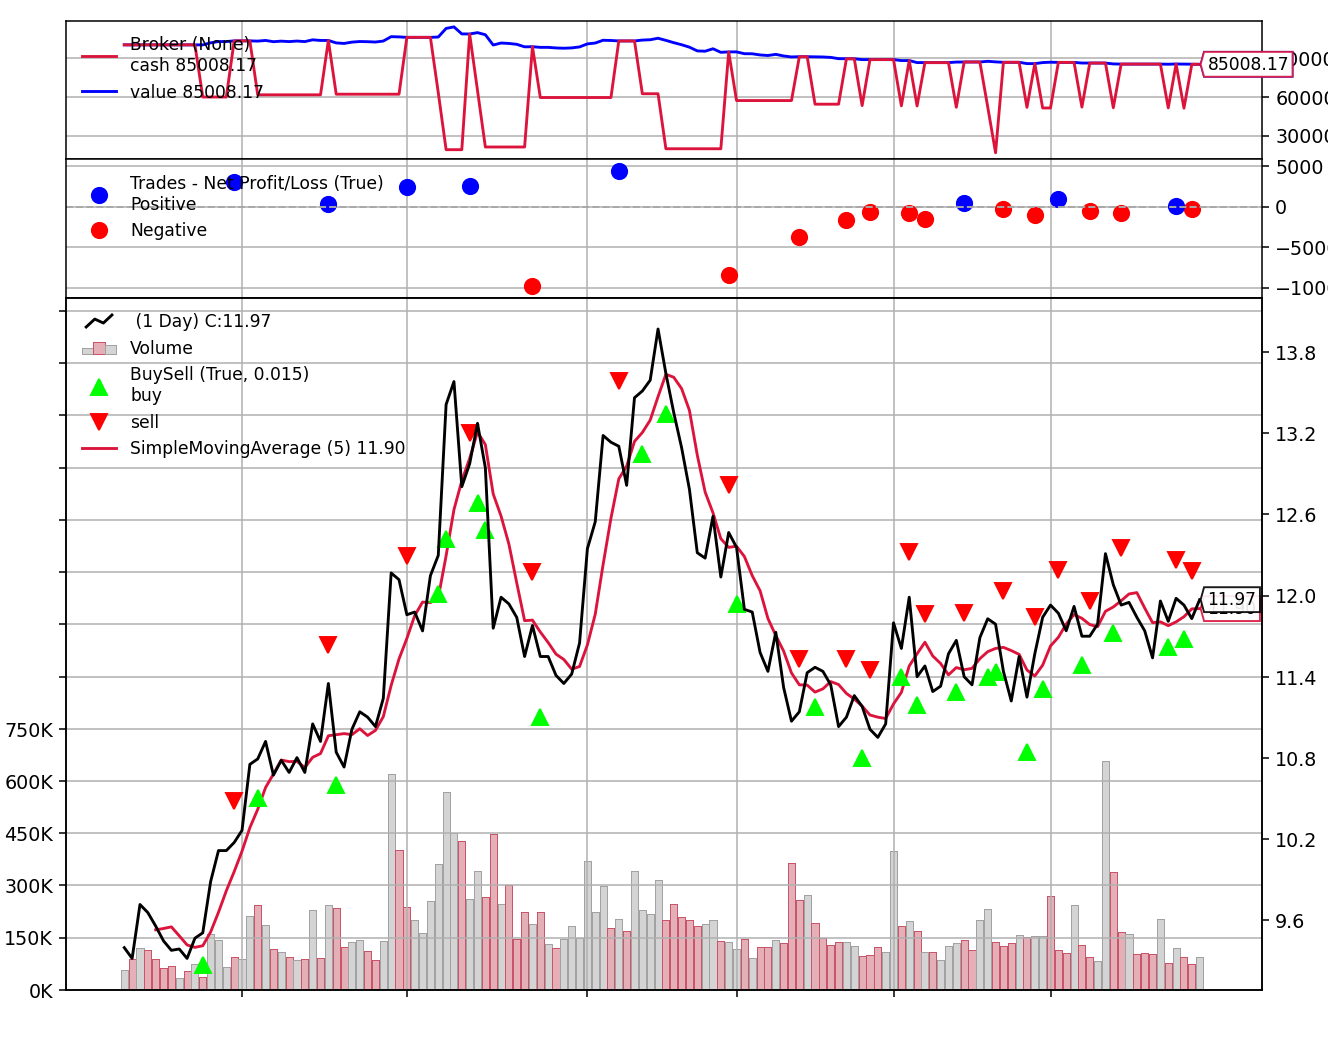

夏普比率 None
最大回撤 25.324532367709317
OrderedDict([(2023, -0.14991827964471915)])


In [36]:
    cerebro=bt.Cerebro()
    cerebro.adddata(res)
    cerebro.addstrategy(st)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio,_name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown,_name='DrawDown')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn,_name='AnnualReturn')
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.0006)
    cerebro.addsizer(bt.sizers.PercentSizer,percents=40)
    result=cerebro.run()
    cerebro.plot()
    print('夏普比率',result[0].analyzers.SharpeRatio.get_analysis()['sharperatio'])
    print('最大回撤',result[0].analyzers.DrawDown.get_analysis()['max']['drawdown'])
    print(result[0].analyzers.AnnualReturn.get_analysis())

<IPython.core.display.Javascript object>


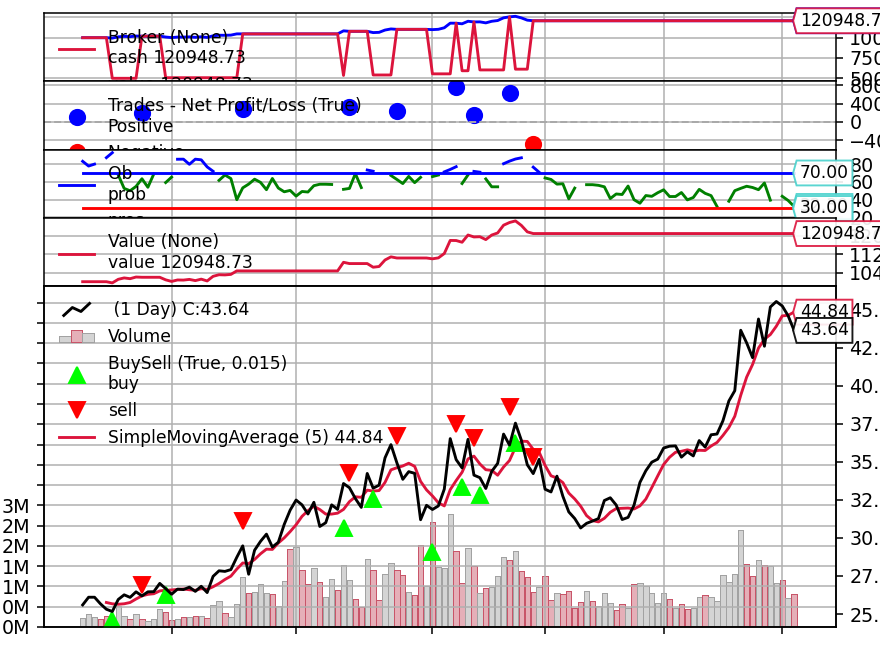

夏普比率 None
最大回撤 4.352175008138011
OrderedDict([(2023, 0.20948729832862)])


In [179]:
    cerebro=bt.Cerebro()
    cerebro.adddata(res)
    cerebro.addstrategy(st10)
    cerebro.addobserver(Ob)
    cerebro.addanalyzer(bt.analyzers.DrawDown,_name='DrawDown')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn,_name='AnnualReturn')
    cerebro.addobserver(bt.observers.Value)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio,_name='SharpeRatio')
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.0006)
    cerebro.addsizer(bt.sizers.PercentSizer,percents=50)
    result=cerebro.run()
    cerebro.plot()
    print('夏普比率',result[0].analyzers.SharpeRatio.get_analysis()['sharperatio'])
    print('最大回撤',result[0].analyzers.DrawDown.get_analysis()['max']['drawdown'])
    print(result[0].analyzers.AnnualReturn.get_analysis())